In [1]:
# data manipulation and plotting
import pandas as pd
import numpy as np
from numpy import NaN
import matplotlib.pyplot as plt

# for saving the pipeline
import joblib

# from Scikit-learn
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Binarizer

# from feature-engine
from feature_engine.imputation import (
    AddMissingIndicator,
    MeanMedianImputer,
    CategoricalImputer,
)

from feature_engine.encoding import (
    RareLabelEncoder,
    OrdinalEncoder,
)

from feature_engine.transformation import LogTransformer

from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

In [2]:
#load data
data_features = pd.read_csv("/Users/afanzott/Documents/RHI_Data_Science/research_notebooks/data/md_raw_dataset.csv", sep=";", index_col=False)
target = pd.read_csv("/Users/afanzott/Documents/RHI_Data_Science/research_notebooks/data/md_target_dataset.csv", sep=";")

#rename first column
data_features.rename(columns = {"Unnamed: 0":"index"}, inplace=True)
data_features.groups = data_features.groups.astype("int64", errors="ignore")

#merge both tables wrt groups & index
data_features = data_features.loc[~data_features.groups.isnull(), :]
data = pd.merge(data_features, target, how="inner", on=["groups","index"])

data.head()


,index,when,super_hero_group,tracking,place,tracking_times,crystal_type,Unnamed: 7,human_behavior_report,human_measure,crystal_weight,expected_factor_x,previous_factor_x,first_factor_x,expected_final_factor_x,final_factor_x,previous_adamantium,Unnamed: 17,etherium_before_start,expected_start,start_process,start_subprocess1,start_critical_subprocess1,predicted_process_end,process_end,subprocess1_end,reported_on_tower,opened,chemical_x,raw_kryptonite,argon,pure_seastone,crystal_supergroup,Cycle,groups,target
0,1,09/07/2020,D,84941,1,1,group 56,1,4,700,350.6301,1610,1630.300049,1595.0,1565.0,1572.0,0.0309,1595.0,NaN,09/07/2020 15:08,09/07/2020 15:11,09/07/2020 15:16,09/07/2020 15:18,09/07/2020 15:49,09/07/2020 15:39,09/07/2020 15:38,09/07/2020 15:53,44021.6737,21.966667,3570.0,0.0,99.94,0,2ª,0.0,1.233766
1,2,09/07/2020,D,84951,1,1,group 56,2,4,800,347.4298,1609,1638.099976,1608.0,1565.0,1568.0,NaN,1608.0,NaN,09/07/2020 16:15,09/07/2020 16:16,09/07/2020 16:20,09/07/2020 16:22,09/07/2020 16:54,09/07/2020 16:42,09/07/2020 16:41,09/07/2020 16:54,44021.70867,21.166667,7950.0,0.0,91.49,0,2ª,0.0,2.467532
2,3,09/07/2020,D,84971,1,1,group 56,7,3,700,333.1576,1622,1614.099976,1587.0,1571.0,1576.0,0.0520,1587.0,NaN,09/07/2020 18:22,09/07/2020 18:24,09/07/2020 18:31,09/07/2020 18:33,09/07/2020 19:02,09/07/2020 18:47,09/07/2020 18:47,09/07/2020 18:55,09/07/2020 19:02,15.250000,807.0,0.0,NaN,0,2ª,0.0,3.701299
3,4,09/07/2020,D,84981,1,1,group 27,17,3,700,362.3764,1620,1618.199951,1599.0,1579.0,1590.0,0.2800,1599.0,NaN,09/07/2020 19:14,09/07/2020 19:12,09/07/2020 19:16,NaN,09/07/2020 20:13,09/07/2020 19:37,09/07/2020 19:37,09/07/2020 19:47,09/07/2020 20:20,20.566667,NaN,0.0,509.19,0,2ª,0.0,4.935065
4,5,09/07/2020,B,84991,1,1,group 56,12,3,720,349.7962,1634,1640.500000,1617.0,1583.0,1589.0,0.0406,1617.0,NaN,09/07/2020 20:59,09/07/2020 20:59,09/07/2020 21:03,09/07/2020 21:04,09/07/2020 21:37,09/07/2020 21:35,09/07/2020 21:35,09/07/2020 21:51,09/07/2020 22:09,32.016667,1026.0,0.0,127.79,0,2ª,0.0,6.168831


In [3]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['target'], axis=1), # predictive variables
    data['target'], # target
    test_size=0.1, # portion of dataset to allocate to test set
    random_state=0, # we are setting the seed here
)

X_train.shape, X_test.shape

((7689, 35), (855, 35))

# Feature Engineering

In the following cells, we will engineer the variables of the House Price Dataset so that we tackle:

- Missing values
- Temporal variables
- Non-Gaussian distributed variables
- Categorical variables: remove rare labels
- Categorical variables: convert strings to numbers
- Standardize the values of the variables to the same range

# Temporal values

In [4]:
temp_vars = ["when", "expected_start", "start_process", "start_subprocess1", "start_critical_subprocess1", "predicted_process_end", "process_end", "subprocess1_end", "reported_on_tower", "opened"]

for var in temp_vars:
    X_train.loc[pd.to_datetime(X_train[var], utc=True, errors="coerce", dayfirst=True).isna(), var] = NaN
    X_test.loc[pd.to_datetime(X_test[var], utc=True, errors="coerce", dayfirst=True).isna(), var] = NaN

for var in temp_vars:
    X_train[var] = pd.to_datetime(X_train[var], dayfirst=True)
    X_test[var] = pd.to_datetime(X_test[var], dayfirst=True)

In [5]:
def elapsed_time(df, var, var1, var2):
    # capture time difference between two variables
    df[var] = (df[var1] - df[var2]).dt.seconds/60
    df[var].astype("Int64")
    return df

In [6]:
X_train = elapsed_time(X_train, "diff_subprocess1", "subprocess1_end", "start_subprocess1")
X_test = elapsed_time(X_test, "diff_subprocess1", "subprocess1_end", "start_subprocess1")

X_train = elapsed_time(X_train, "diff_expected", "predicted_process_end", "expected_start")
X_test = elapsed_time(X_test, "diff_expected", "predicted_process_end", "expected_start")

X_train = elapsed_time(X_train, "diff_process", "process_end", "start_process")
X_test = elapsed_time(X_test, "diff_process", "process_end", "start_process")

X_train.drop(["start_subprocess1", "subprocess1_end", "expected_start", "predicted_process_end", "start_process", "process_end"], axis=1, inplace=True)
X_test.drop(["start_subprocess1", "subprocess1_end", "expected_start", "predicted_process_end", "start_process", "process_end"], axis=1, inplace=True)

In [7]:
#Split remaining time columns into useful columns
def split_datetime(df, var, date_or_dt):
    if date_or_dt == "date":
        df["year_" + str(var)] = df[var].dt.year
        df["month_" + str(var)] = df[var].dt.month
        df["day_" + str(var)] = df[var].dt.day
    else:
        df["year_" + str(var)] = df[var].dt.year
        df["month_" + str(var)] = df[var].dt.month
        df["day_" + str(var)] = df[var].dt.day
        df["hour_" + str(var)] = df[var].dt.hour
        df["minute_" + str(var)] = df[var].dt.minute
        df["second_" + str(var)] = df[var].dt.second
    
    df.drop([var], axis=1, inplace=True)
    return df

In [8]:
X_train = split_datetime(X_train, "when", date_or_dt="date")
X_test = split_datetime(X_test, "when", date_or_dt="date")

X_train = split_datetime(X_train, "start_critical_subprocess1", date_or_dt="datetime")
X_test = split_datetime(X_test, "start_critical_subprocess1", date_or_dt="datetime")

X_train = split_datetime(X_train, "reported_on_tower", date_or_dt="datetime")
X_test = split_datetime(X_test, "reported_on_tower", date_or_dt="datetime")

X_train = split_datetime(X_train, "opened", date_or_dt="datetime")
X_test = split_datetime(X_test, "opened", date_or_dt="datetime")

In [9]:
#Cast etherium as float64

X_train.etherium_before_start = X_train.etherium_before_start.astype("float64")
X_test.etherium_before_start = X_test.etherium_before_start.astype("float64")

In [10]:
y_train = np.log(y_train)
y_test = np.log(y_test)

In [11]:
cat_vars = [var for var in X_train.columns if X_train[var].dtype == "O"]

cat_vars = cat_vars + ["index", "place", "Unnamed: 7", "human_behavior_report", "groups", "tracking_times"]

# cast all variables as categorical
X_train[cat_vars] = X_train[cat_vars].astype('O')
X_test[cat_vars] = X_test[cat_vars].astype('O')

# number of categorical variables
print(cat_vars)

['super_hero_group', 'crystal_type', 'crystal_supergroup', 'Cycle', 'index', 'place', 'Unnamed: 7', 'human_behavior_report', 'groups', 'tracking_times']


In [12]:
# make a list of the categorical variables that contain missing values

cat_vars_with_na = [
    var for var in cat_vars
    if X_train[var].isnull().sum() > 0
]

# print percentage of missing values per variable
X_train[cat_vars_with_na ].isnull().mean().sort_values(ascending=False)

Series([], dtype: float64)

In [13]:
[var for var in cat_vars_with_na if X_test[var].isnull().sum() > 0]

[]

In [14]:
# now let's identify the numerical variables

num_vars = [
    var for var in X_train.columns if var not in cat_vars
]

# number of numerical variables
len(num_vars)

39

In [15]:
# make a list with the numerical variables that contain missing values
vars_with_na = [
    var for var in num_vars
    if X_train[var].isnull().sum() > 0
]

# print percentage of missing values per variable
X_train[vars_with_na].isnull().mean().sort_values(ascending=False)

etherium_before_start                0.675510
raw_kryptonite                       0.473404
day_start_critical_subprocess1       0.319157
month_start_critical_subprocess1     0.319157
second_start_critical_subprocess1    0.319157
minute_start_critical_subprocess1    0.319157
hour_start_critical_subprocess1      0.319157
year_start_critical_subprocess1      0.319157
pure_seastone                        0.108076
minute_opened                        0.044739
hour_opened                          0.044739
day_opened                           0.044739
month_opened                         0.044739
year_opened                          0.044739
second_opened                        0.044739
argon                                0.036286
previous_adamantium                  0.030433
diff_expected                        0.030303
crystal_weight                       0.027442
year_reported_on_tower               0.020679
month_reported_on_tower              0.020679
day_reported_on_tower             

In [16]:
vars_with_na

['crystal_weight',
 'first_factor_x',
 'final_factor_x',
 'previous_adamantium',
 'Unnamed: 17',
 'etherium_before_start',
 'chemical_x',
 'raw_kryptonite',
 'argon',
 'pure_seastone',
 'diff_subprocess1',
 'diff_expected',
 'diff_process',
 'year_start_critical_subprocess1',
 'month_start_critical_subprocess1',
 'day_start_critical_subprocess1',
 'hour_start_critical_subprocess1',
 'minute_start_critical_subprocess1',
 'second_start_critical_subprocess1',
 'year_reported_on_tower',
 'month_reported_on_tower',
 'day_reported_on_tower',
 'hour_reported_on_tower',
 'minute_reported_on_tower',
 'second_reported_on_tower',
 'year_opened',
 'month_opened',
 'day_opened',
 'hour_opened',
 'minute_opened',
 'second_opened']

In [17]:
# add missing indicator

missing_ind = AddMissingIndicator(variables=vars_with_na)

missing_ind.fit(X_train)

X_train = missing_ind.transform(X_train)
X_test = missing_ind.transform(X_test)

# check the binary missing indicator variables
X_train[vars_with_na].head()

,crystal_weight,first_factor_x,final_factor_x,previous_adamantium,Unnamed: 17,etherium_before_start,chemical_x,raw_kryptonite,argon,pure_seastone,diff_subprocess1,diff_expected,diff_process,year_start_critical_subprocess1,month_start_critical_subprocess1,day_start_critical_subprocess1,hour_start_critical_subprocess1,minute_start_critical_subprocess1,second_start_critical_subprocess1,year_reported_on_tower,month_reported_on_tower,day_reported_on_tower,hour_reported_on_tower,minute_reported_on_tower,second_reported_on_tower,year_opened,month_opened,day_opened,hour_opened,minute_opened,second_opened
2709,348.0064,1566.000000,1553.0,0.0302,1566.000000,NaN,27.433333,NaN,232.156922,163.69,27.0,61.0,58.0,2020.0,10.0,22.0,8.0,24.0,0.0,2020.0,10.0,22.0,9.0,39.0,0.0,2020.0,10.0,22.0,9.0,44.0,0.0
3472,338.4761,1602.000000,1588.0,0.3130,1602.000000,485.200012,37.366667,NaN,198.546729,465.50,37.0,50.0,49.0,2019.0,6.0,30.0,2.0,58.0,0.0,2019.0,6.0,30.0,3.0,40.0,0.0,2019.0,6.0,30.0,3.0,45.0,0.0
1830,339.8825,1593.000000,1593.0,0.3030,1593.000000,NaN,11.033333,NaN,0.000000,509.49,11.0,26.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,2020.0,7.0,30.0,23.0,16.0,0.0,2020.0,7.0,30.0,23.0,23.0,0.0
15,348.3889,1600.000000,1596.0,0.0412,1600.000000,NaN,16.266667,NaN,0.000000,468.15,16.0,45.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,2020.0,7.0,10.0,15.0,39.0,0.0,2020.0,7.0,10.0,16.0,24.0,0.0
8211,320.6401,1599.300049,1579.0,0.0197,1599.300049,NaN,34.433333,821.0,181.294678,247.45,35.0,37.0,47.0,2020.0,8.0,1.0,9.0,17.0,0.0,2020.0,8.0,1.0,10.0,25.0,0.0,2020.0,8.0,1.0,10.0,38.0,0.0


In [18]:
# then replace missing data with the mean

# set the imputer
mean_imputer = MeanMedianImputer(
    imputation_method='mean', variables=vars_with_na)

# learn and store parameters from train set
mean_imputer.fit(X_train)

# the stored parameters
mean_imputer.imputer_dict_

{'crystal_weight': 341.94889616207485,
 'first_factor_x': 1593.7066287532573,
 'final_factor_x': 1580.8758024539452,
 'previous_adamantium': 0.13446315224681388,
 'Unnamed: 17': 1593.7066287532573,
 'etherium_before_start': 441.51025331497766,
 'chemical_x': 30.24571817147272,
 'raw_kryptonite': 2331.607310447024,
 'argon': 142.7051632185535,
 'pure_seastone': 385.0847987751533,
 'diff_subprocess1': 29.720810846386733,
 'diff_expected': 45.81410944206009,
 'diff_process': 38.968632044774175,
 'year_start_critical_subprocess1': 2019.7276026743075,
 'month_start_critical_subprocess1': 6.246800382043935,
 'day_start_critical_subprocess1': 15.28748806112703,
 'hour_start_critical_subprocess1': 11.312702960840497,
 'minute_start_critical_subprocess1': 29.910792741165235,
 'second_start_critical_subprocess1': 0.0,
 'year_reported_on_tower': 2019.7148738379815,
 'month_reported_on_tower': 6.536653386454184,
 'day_reported_on_tower': 15.365205843293493,
 'hour_reported_on_tower': 11.4657370517

In [19]:
X_train = mean_imputer.transform(X_train)
X_test = mean_imputer.transform(X_test)

# we could save the imputers with joblib

# check that we have no more missing values in the engineered variables
X_train[vars_with_na].isnull().sum()

crystal_weight                       0
first_factor_x                       0
final_factor_x                       0
previous_adamantium                  0
Unnamed: 17                          0
etherium_before_start                0
chemical_x                           0
raw_kryptonite                       0
argon                                0
pure_seastone                        0
diff_subprocess1                     0
diff_expected                        0
diff_process                         0
year_start_critical_subprocess1      0
month_start_critical_subprocess1     0
day_start_critical_subprocess1       0
hour_start_critical_subprocess1      0
minute_start_critical_subprocess1    0
second_start_critical_subprocess1    0
year_reported_on_tower               0
month_reported_on_tower              0
day_reported_on_tower                0
hour_reported_on_tower               0
minute_reported_on_tower             0
second_reported_on_tower             0
year_opened              

In [20]:
# check that test set does not contain null values in the engineered variables

[var for var in vars_with_na if X_test[var].isnull().sum() > 0]

[]

Logarithmic transformation of variables

In [21]:
log_transformer = LogTransformer(
    variables=["crystal_weight", "chemical_x", "final_factor_x", "pure_seastone"])

X_train = log_transformer.fit_transform(X_train)
X_test = log_transformer.transform(X_test)

In [22]:
# check that test set does not contain null values in the engineered variables
[var for var in ["crystal_weight", "chemical_x", "final_factor_x", "pure_seastone"] if X_test[var].isnull().sum() > 0]

[]

In [23]:
# same for train set
[var for var in ["crystal_weight", "chemical_x", "final_factor_x", "pure_seastone"] if X_train[var].isnull().sum() > 0]

[]

# Removing Rare Labels

For the not integer based categorical variables, we will group those categories that are present in less than 1% of the observations. That is, all values of categorical variables that are shared by less than 1% of data points, well be replaced by the string "Rare".

In [24]:
#categorical with qualitative variables

cat_others = ["super_hero_group", "crystal_type", "Cycle"]

In [25]:
rare_encoder = RareLabelEncoder(tol=0.01, n_categories=1, variables=cat_others)

# find common labels
rare_encoder.fit(X_train)

# the common labels are stored, we can save the class
# and then use it later 
rare_encoder.encoder_dict_

{'super_hero_group': Index(['B', 'D', 'A', 'C', 'G', 'W', 'Y'], dtype='object'),
 'crystal_type': Index(['group 67', 'group 203', 'group 196', 'group 5', 'group 35',
        'group 184', 'group 112', 'group 197', 'group 70', 'group 183',
        'group 190', 'group 1', 'group 186', 'group 202', 'group 145',
        'group 22', 'group 160', 'group 27', 'group 29', 'group 92', 'group 3',
        'group 78', 'group 56', 'group 155', 'group 180', 'group 2', 'group 7',
        'group 204'],
       dtype='object'),
 'Cycle': Index(['1ª', '2ª', '131', '3ª'], dtype='object')}

In [26]:
X_train = rare_encoder.transform(X_train)
X_test = rare_encoder.transform(X_test)

In [27]:
X_train[X_train.crystal_type == "Rare"]

,index,super_hero_group,tracking,place,tracking_times,crystal_type,Unnamed: 7,human_behavior_report,human_measure,crystal_weight,expected_factor_x,previous_factor_x,first_factor_x,expected_final_factor_x,final_factor_x,previous_adamantium,Unnamed: 17,etherium_before_start,chemical_x,raw_kryptonite,argon,pure_seastone,crystal_supergroup,Cycle,groups,diff_subprocess1,diff_expected,diff_process,year_when,month_when,day_when,year_start_critical_subprocess1,month_start_critical_subprocess1,day_start_critical_subprocess1,hour_start_critical_subprocess1,minute_start_critical_subprocess1,second_start_critical_subprocess1,year_reported_on_tower,month_reported_on_tower,day_reported_on_tower,hour_reported_on_tower,minute_reported_on_tower,second_reported_on_tower,year_opened,month_opened,day_opened,hour_opened,minute_opened,second_opened,crystal_weight_na,first_factor_x_na,final_factor_x_na,previous_adamantium_na,Unnamed: 17_na,etherium_before_start_na,chemical_x_na,raw_kryptonite_na,argon_na,pure_seastone_na,diff_subprocess1_na,diff_expected_na,diff_process_na,year_start_critical_subprocess1_na,month_start_critical_subprocess1_na,day_start_critical_subprocess1_na,hour_start_critical_subprocess1_na,minute_start_critical_subprocess1_na,second_start_critical_subprocess1_na,year_reported_on_tower_na,month_reported_on_tower_na,day_reported_on_tower_na,hour_reported_on_tower_na,minute_reported_on_tower_na,second_reported_on_tower_na,year_opened_na,month_opened_na,day_opened_na,hour_opened_na,minute_opened_na,second_opened_na
2709,19,D,602491,1,1,Rare,10,4,650,5.852221,1616,1596.199951,1566.000000,1553.0,7.347944,0.0302,1566.000000,441.510253,3.311759,2331.60731,232.156922,5.097974,0,2ª,53.0,27.0,61.000000,58.0,2020,10,22,2020.000000,10.0000,22.000000,8.000000,24.000000,0.0,2020.0,10.0,22.0,9.0,39.0,0.0,2020.0,10.0,22.0,9.0,44.0,0.0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8211,5,B,89261,2,1,Rare,12,4,580,5.770319,1633,1622.500000,1599.300049,1576.0,7.364547,0.0197,1599.300049,441.510253,3.539025,821.00000,181.294678,5.511209,0,2ª,62.0,35.0,37.000000,47.0,2020,8,1,2020.000000,8.0000,1.000000,9.000000,17.000000,0.0,2020.0,8.0,1.0,10.0,25.0,0.0,2020.0,8.0,1.0,10.0,38.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4390,68,C,87761,2,1,Rare,6,3,740,5.822321,1623,1592.199951,1575.199951,1571.0,7.365560,0.0499,1575.199951,441.510253,3.738859,2331.60731,517.178040,6.078376,0,1ª,2.0,42.0,55.000000,54.0,2020,7,24,2020.000000,7.0000,24.000000,4.000000,28.000000,0.0,2020.0,7.0,24.0,5.0,11.0,0.0,2020.0,7.0,24.0,5.0,15.0,0.0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5962,4,C,101401,2,1,Rare,20,3,550,5.834661,1623,1614.199951,1593.099976,1577.0,7.379195,0.0356,1593.099976,3.332000,4.083452,10537.00000,903.768738,6.685774,0,2ª,21.0,60.0,45.814109,66.0,2020,10,1,2020.000000,10.0000,1.000000,13.000000,24.000000,0.0,2020.0,10.0,1.0,15.0,54.0,0.0,2020.0,10.0,1.0,16.0,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2658,72,B,570711,1,1,Rare,16,3,670,5.806278,1627,1635.699951,1616.000000,1574.0,7.370860,0.0450,1616.000000,2.616000,3.336955,984.00000,72.648695,3.453157,0,2ª,52.0,28.0,45.000000,43.0,2020,4,13,2019.727603,6.2468,15.287488,11.312703,29.910793,0.0,2020.0,4.0,13.0,6.0,23.0,0.0,2020.0,4.0,13.0,6.0,31.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2599,13,A,570101,1,1,Rare,8,4,700,5.808536,1641,1620.900024,1582.000000,1571.0,7.364547,0.3310,1582.000000,317.700012,3.316607,524.00000,0.000000,6.337003,0,2ª,52.0,28.0,47.000000,35.0,2020,4,9,2020.000000,4.0000,9.000000,1.000000,34.000000,0.0,2020.0,4.0,9.0,2.0,3.0,0.0,2020.0,4.0,9.0,2.0,10

# Encoding of categorical variables

Next, we need to transform the strings of the categorical variables into numbers.
We will do it so that we capture the monotonic relationship between the label and the target.

In [28]:
# set up the encoder
cat_encoder = OrdinalEncoder(encoding_method='ordered', variables=cat_others)

# create the mappings
cat_encoder.fit(X_train, y_train)

# mappings are stored and class can be saved
cat_encoder.encoder_dict_

{'super_hero_group': {'Y': 0,
  'W': 1,
  'G': 2,
  'D': 3,
  'C': 4,
  'B': 5,
  'A': 6,
  'Rare': 7},
 'crystal_type': {'group 27': 0,
  'group 1': 1,
  'group 3': 2,
  'group 160': 3,
  'group 180': 4,
  'group 67': 5,
  'group 190': 6,
  'group 56': 7,
  'group 7': 8,
  'group 5': 9,
  'group 196': 10,
  'group 2': 11,
  'group 145': 12,
  'group 184': 13,
  'group 22': 14,
  'group 203': 15,
  'group 29': 16,
  'group 202': 17,
  'Rare': 18,
  'group 112': 19,
  'group 78': 20,
  'group 35': 21,
  'group 204': 22,
  'group 155': 23,
  'group 70': 24,
  'group 197': 25,
  'group 186': 26,
  'group 183': 27,
  'group 92': 28},
 'Cycle': {'131': 0, '1ª': 1, '2ª': 2, '3ª': 3}}

In [29]:
X_train = cat_encoder.transform(X_train)
X_test = cat_encoder.transform(X_test)

In [30]:
# check absence of na in the train set
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

[]

In [31]:
# check absence of na in the test set
[var for var in X_test.columns if X_test[var].isnull().sum() > 0]

[]

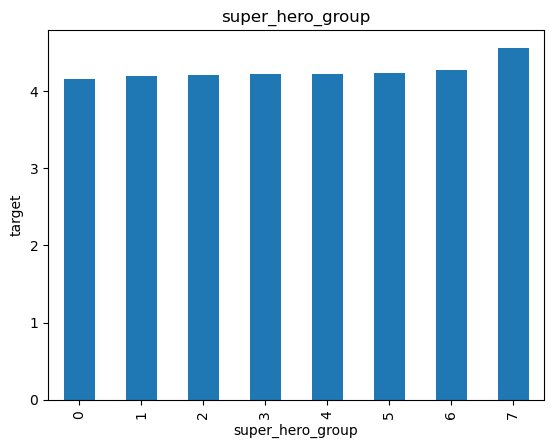

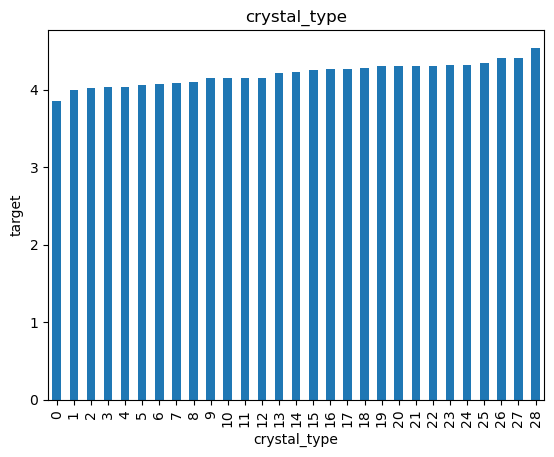

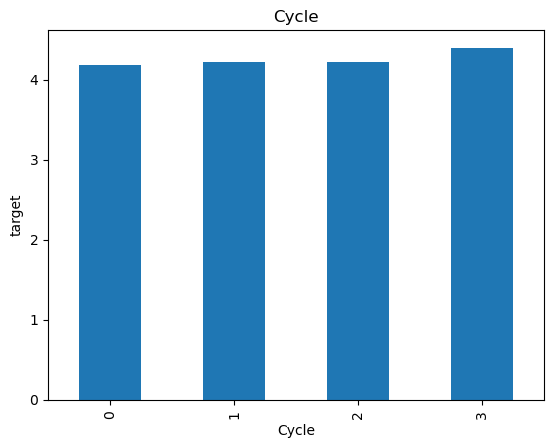

In [32]:
def analyse_vars(train, y_train, var):
    
    # function plots median target value per encoded category
    
    tmp = pd.concat([X_train, y_train], axis=1)
    
    tmp.groupby(var)['target'].mean().plot.bar()
    plt.title(var)
    plt.ylabel('target')
    plt.show()
    
for var in cat_others:
    analyse_vars(X_train, y_train, var)

# Feature Scaling

In [33]:
# create scaler
scaler = MinMaxScaler()

#  fit  the scaler to the train set
scaler.fit(X_train) 

# transform the train and test set

# sklearn returns numpy arrays, so we wrap the
# array with a pandas dataframe

X_train = pd.DataFrame(
    scaler.transform(X_train),
    columns=X_train.columns
)

X_test = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_train.columns
)

In [34]:
X_train.head()

,index,super_hero_group,tracking,place,tracking_times,crystal_type,Unnamed: 7,human_behavior_report,human_measure,crystal_weight,expected_factor_x,previous_factor_x,first_factor_x,expected_final_factor_x,final_factor_x,previous_adamantium,Unnamed: 17,etherium_before_start,chemical_x,raw_kryptonite,argon,pure_seastone,crystal_supergroup,Cycle,groups,diff_subprocess1,diff_expected,diff_process,year_when,month_when,day_when,year_start_critical_subprocess1,month_start_critical_subprocess1,day_start_critical_subprocess1,hour_start_critical_subprocess1,minute_start_critical_subprocess1,second_start_critical_subprocess1,year_reported_on_tower,month_reported_on_tower,day_reported_on_tower,hour_reported_on_tower,minute_reported_on_tower,second_reported_on_tower,year_opened,month_opened,day_opened,hour_opened,minute_opened,second_opened,crystal_weight_na,first_factor_x_na,final_factor_x_na,previous_adamantium_na,Unnamed: 17_na,etherium_before_start_na,chemical_x_na,raw_kryptonite_na,argon_na,pure_seastone_na,diff_subprocess1_na,diff_expected_na,diff_process_na,year_start_critical_subprocess1_na,month_start_critical_subprocess1_na,day_start_critical_subprocess1_na,hour_start_critical_subprocess1_na,minute_start_critical_subprocess1_na,second_start_critical_subprocess1_na,year_reported_on_tower_na,month_reported_on_tower_na,day_reported_on_tower_na,hour_reported_on_tower_na,minute_reported_on_tower_na,second_reported_on_tower_na,year_opened_na,month_opened_na,day_opened_na,hour_opened_na,minute_opened_na,second_opened_na
0,0.125000,0.428571,0.954742,0.0,0.0,0.642857,0.473684,1.000000,0.490741,0.772396,0.297297,0.356616,0.440217,0.245455,0.558046,0.045111,0.440217,0.384121,0.754144,0.100159,0.163799,0.579159,0.0,0.666667,0.716216,0.257143,0.042747,0.479339,0.5,0.818182,0.700000,0.500000,0.818182,0.700000,0.347826,0.406780,0.0,0.5,0.818182,0.700000,0.391304,0.661017,0.0,0.5,0.818182,0.700000,0.391304,0.745763,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.493421,0.285714,0.021300,0.0,0.0,0.964286,0.842105,0.000000,0.518519,0.698589,0.635135,0.548545,0.635870,0.590909,0.709157,0.473206,0.635870,0.422208,0.810842,0.100159,0.140086,0.745054,1.0,0.333333,0.878378,0.352381,0.035039,0.404959,0.0,0.454545,0.966667,0.000000,0.454545,0.966667,0.086957,0.983051,0.0,0.0,0.454545,0.966667,0.130435,0.677966,0.0,0.0,0.454545,0.966667,0.130435,0.762712,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.361842,0.857143,0.127477,0.0,0.0,0.678571,0.526316,0.666667,0.425926,0.709611,0.364865,0.494226,0.586957,0.645455,0.730472,0.458068,0.586957,0.384121,0.587025,0.100159,0.000000,0.759387,0.0,0.333333,0.540541,0.104762,0.018220,0.148760,0.5,0.545455,0.966667,0.363801,0.476982,0.476250,0.491857,0.506963,0.0,0.5,0.545455,0.966667,1.000000,0.271186,0.0,0.5,0.545455,0.966667,1.000000,0.389831,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.105263,0.428571,0.121242,0.0,0.0,0.000000,0.421053,0.333333,0.518519,0.775316,0.425676,0.532853,0.625000,0.509091,0.743229,0.061762,0.625000,0.384121,0.658251,0.100159,0.000000,0.745955,0.0,0.666667,0.000000,0.152381,0.031535,0.190083,0.5,0.545455,0.300000,0.363801,0.476982,0.476250,0.491857,0.506963,0.0,0.5,0.545455,0.300000,0.652174,0.661017,0.0,0.5,0.545455,0.300000,0.695652,0.406780,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.032895,0.714286,0.127832,1.0,0.0,0.642857,0.578947,1.000000,0.425926,0.554699,0.412162,0.515350,0.621196,0.454545,0.670621,0.029216,0.621196,0.384121,0.795842,0.035240,0.127913,0.644752,0.0,0.666667,0.837838,0.333333,0.025929,0.388430,0.5,0.636364,0.000000,0.500000,0.636364,0.000000,0.391304,0.288136,0.0,0.5,0.636364,0.000000,0.434783,0.423729,0.0,0.5,0.636364,0.000000,0